# Import dependencies

In [377]:
# Import management
from importlib import reload

# Data Manipulations and Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler

# Data Visualization
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import train_test_split

# Services
import services.ModelStageService as sds

# utils
import datetime
import utils.EDAUtils as edaUtils
import utils.ModelTrainingAndEvaluationUtils as mteUtils
import utils.DataTransformationUtils as dtUtils
import utils.PlottingUtils as pltUtils

reload(sds)
reload(edaUtils)
reload(mteUtils)
reload(dtUtils)
reload(pltUtils)

stage_data_io_service = sds.ModelStageService(previous_stage_name=sds.PREPROCESSING_STAGE, current_stage_name=sds.FEATURE_ENGINEERING_STAGE)

# Load data

In [350]:
# Reading text from txt file
df = stage_data_io_service.run_or_load_stage_data(reload_stage=False)

Reload stage False path ../../data/stages/PREPROCESSING_stage_data.pkl exists True
Loading PREPROCESSING from snapshot.
Loading PREPROCESSING from snapshot.


# Feature Engineering and Data Processing for Model Building

## Adding Synthetic Replenishment Data for Accurate Calculation of Credit Debt Repayment Stability (CDRS) Ratio

Before calculating the Credit Debt Repayment Stability (CDRS) ratio, it is crucial to account for all transactions affecting the available balance, especially replenishments. However, the dataset lacks direct information on replenishment transactions, except for specific cases like reversal transactions. This absence introduces potential inaccuracies when calculating repayment stability.

To resolve this issue without altering the data schema by adding new markers, we will synthetically generate missing replenishment transactions. The approach works as follows:

1. **Data Grouping and Sorting**: We group the transactions by account number and arrange them in chronological order to establish a clear transaction flow.
   
2. **Pairwise Transaction Comparison**: After sorting, we compare each transaction with the preceding one. If the available balance of the current transaction exceeds that of the previous one and the previous transaction is not classified as a reversal or address verification, we infer that a replenishment transaction was missing between the two.

3. **Synthetic Replenishment Insertion**: For each identified gap, a synthetic replenishment transaction is inserted with a calculated amount and timestamp. This ensures that all changes in the available balance are accurately reflected in the dataset, allowing for a more precise calculation of the CDRS ratio.

By synthesizing replenishment data in this way, we can achieve a more accurate and realistic assessment of credit debt 
repayment behavior without distorting the original dataset's structure.


In [351]:
def add_skipped_replenishment_transactions(df):
    """
    Adds synthetic replenishment transactions to a DataFrame of financial transactions.

    The method processes transaction data for each account, ensuring replenishment transactions 
    are inserted when missing. It works by grouping transactions by account number, 
    sorting them chronologically, and checking if a replenishment transaction is needed 
    between consecutive transactions. If the available balance of a later transaction 
    is greater than the previous one (and the previous transaction is not a reversal or address verification), 
    a replenishment transaction is added synthetically.

    Parameters:
    df (pd.DataFrame): DataFrame containing transaction data.

    Returns:
    pd.DataFrame: The original DataFrame with added synthetic replenishment transactions. 
    The output will be sorted by 'accountNumber' and 'transactionDateTime'.
    """

    # Sort data by account number and transaction datetime
    df = df.sort_values(['accountNumber', 'transactionDateTime']).reset_index(drop=True)

    # List to store new replenishment transactions
    replenishments = []

    # Group transactions by account number
    grouped = df.groupby('accountNumber')

    # Iterate over each account group
    for account, group in grouped:
        # Create a replenishment before the first transaction
        first_transaction = group.iloc[0]
        replenish_row = first_transaction.copy()
        replenish_row['transactionDateTime'] = first_transaction['transactionDateTime'] - datetime.timedelta(days=1)
        replenish_row['transactionAmount'] = first_transaction['creditLimit']
        replenish_row['enteredCVV'] = first_transaction['cardCVV']
        replenish_row['transactionType'] = 'REPLENISHMENT'
        replenish_row['isFraud'] = False
        replenishments.append(replenish_row)

        # Process the rest of the transactions
        for i in range(1, len(group)):
            current_transaction = group.iloc[i]
            previous_transaction = group.iloc[i - 1]

            # Check if a replenishment is needed between transactions
            if (current_transaction['availableMoney'] >= previous_transaction['availableMoney'] and
                    previous_transaction['transactionAmount'] != 0 and
                    previous_transaction['transactionType'] not in ['REVERSAL', 'ADDRESS_VERIFICATION']):
                # Calculate the replenishment datetime
                difference = current_transaction['transactionDateTime'] - previous_transaction['transactionDateTime']
                replenishment_transaction_date_time = (
                    current_transaction['transactionDateTime'] if difference <= datetime.timedelta(0)
                    else current_transaction['transactionDateTime'] - difference / 2
                )

                # Create replenishment transaction
                replenish_row = previous_transaction.copy()
                replenish_row['transactionDateTime'] = replenishment_transaction_date_time
                replenish_row['availableMoney'] = previous_transaction['availableMoney'] - previous_transaction[
                    'transactionAmount']
                replenish_row['creditDebt'] = previous_transaction['creditDebt'] + previous_transaction[
                    'transactionAmount']
                replenish_row['transactionAmount'] = current_transaction['availableMoney'] - replenish_row[
                    'availableMoney']
                replenish_row['enteredCVV'] = previous_transaction['cardCVV']
                replenish_row['transactionType'] = 'REPLENISHMENT'
                replenish_row['isFraud'] = False

                # Append replenishment to the list
                replenishments.append(replenish_row)

    # Convert replenishments to DataFrame and merge with the original DataFrame
    replenishment_df = pd.DataFrame(replenishments)
    result_df = pd.concat([df, replenishment_df]).sort_values(['accountNumber', 'transactionDateTime']).reset_index(
        drop=True)

    return result_df


# Example call of the function
df = stage_data_io_service.run_or_load_snapshot_data('add_skipped_replenishment_transactions', add_skipped_replenishment_transactions, df, recreate_snapshot=False)


Loading add_skipped_replenishment_transactions from snapshot.


In [352]:
# Check dimension after adding new rows

edaUtils.data_summary(df)

Dimensions: 855029 rows, 21 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    567314          0         
transactionDateTime                    datetime64[ns] 844349          0         
transactionAmount                      float64    106311          0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

## Credit debt repayment stability ratio (CDRS Ratio)

### Overview
The primary goal of this analysis is to explore the relationship between a customer's spending and repayment patterns and the likelihood of fraudulent activity (`isFraud`). Specifically, we calculate a **stability coefficient** that reflects how consistently a customer closes their credit debt over time, then analyze how this coefficient correlates with fraud probability.

### Key Variables

1. **Spending Percentage**: The percentage of the credit limit that was spent between full debt repayments.
 $$ \text{Spent Percentage} = \left( \frac{\text{Total Amount Spent}}{\text{Credit Limit}} \right) \times 100 $$

2. **Days Between Resets**: The number of days between two consecutive events where the available balance equals the credit limit (i.e., the debt is fully repaid).

### Stability ratio

To measure customer stability, we consider two factors:
- The **average spending percentage** between resets.
- The **average number of days** between resets.

These two values are normalized using Min-Max normalization to bring them into the range of [0, 1]. The final stability coefficient is computed as:

$$ \text{CDRS Ratio} = 1 - (\text{Normalized Spending Percentage Between Resets} \times \text{Normalized Days Between Resets}) $$

This coefficient ranges from 0 to 1, where:
- A value closer to **1** indicates a more stable customer (less spending, more frequent repayments).
- A value closer to **0** indicates less stable repayment behavior.

### Hypothesis
We hypothesize that a higher stability coefficient (more stable customers) correlates with a lower probability of fraudulent activity. Conversely, lower stability may indicate higher fraud risk.

### Fraud Analysis
Once the CDRS Ratio is calculated for each account, we group the accounts into ranges (bins) of stability coefficients and calculate the percentage of fraudulent transactions (`isFraud = True`) in each range. The results are visualized to test the hypothesis.

### Conclusion
This analysis can help identify patterns between customer behavior and fraud risk, providing valuable insights for improving fraud detection models.

### Nice to fix and improve
- Investigate anomaly in cdrs-ratio range from 0.222-0.333 -- 0.333-0.444
- Improve scaling function (when size of input is 1)
- Investigate and fix when normalized `avg_norm_days_between_resets` is NaN (reason might be in scaling function)


Loading calculate_cdrs_ratio from snapshot.


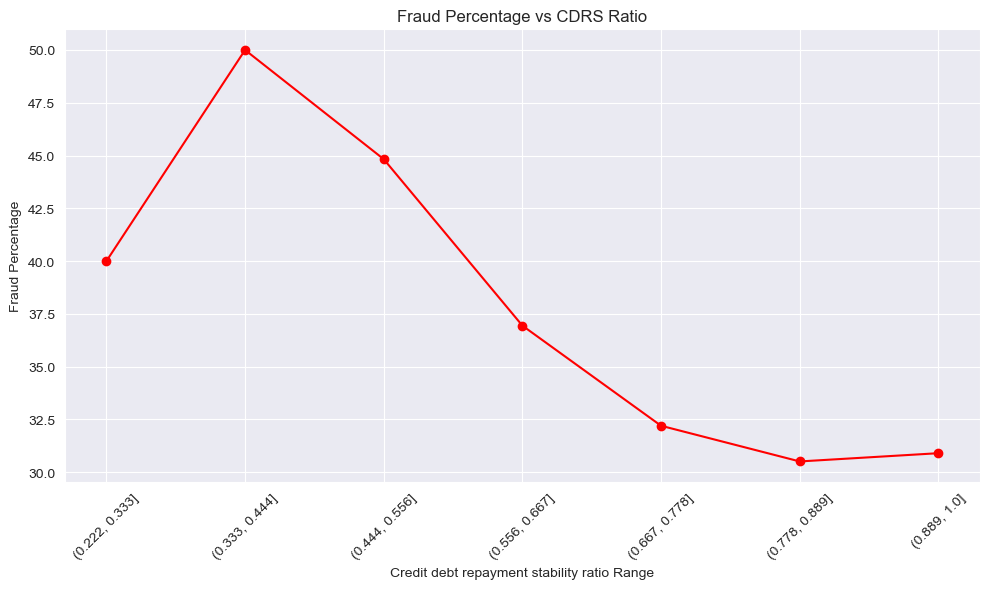

In [353]:

# Function to visualize fraud percentage based on stability coefficient
def visualize_fraud_vs_cdrs_ratio(fraud_stats):
    """
    Visualizes the fraud percentage based on cdrs ratio ranges.

    Parameters:
    fraud_stats: DataFrame containing fraud statistics grouped by cdrs ratio ranges.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(fraud_stats.index.astype(str), fraud_stats['fraud_percentage'], marker='o', linestyle='-', color='r')
    plt.title('Fraud Percentage vs CDRS Ratio')
    plt.xlabel('Credit debt repayment stability ratio Range')
    plt.ylabel('Fraud Percentage')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def calculate_account_stability_stats(account, transactions, reset_indices, stability_data):
    days_between_resets = []
    spent_percentages = []
    # Calculate the amount spent and days between credit limit resets
    for i in range(1, len(reset_indices)):
        start_idx = (reset_indices[i - 1]) + 1  # not include transaction of replenishment
        end_idx = (reset_indices[i]) - 1  # not include transaction of replenishment

        # Exclude replenishment transactions from the spending calculation
        transaction_slice = transactions.loc[start_idx:end_idx]
        non_replenishment_transactions = transaction_slice[
            (transaction_slice['transactionType'] != 'REPLENISHMENT') &
            (transaction_slice['transactionType'] != 'ADDRESS_VERIFICATION') &
            (transaction_slice['transactionType'] != 'REVERSAL')
            ]

        # Calculate the total amount spent between resets
        total_spent = non_replenishment_transactions['transactionAmount'].sum()
        credit_limit = transactions.loc[start_idx, 'creditLimit']

        spent_percentage = abs((total_spent / credit_limit) * 100)
        spent_percentages.append(spent_percentage)

        # Calculate the number of days between the two resets
        start_date = transactions.loc[start_idx, 'transactionDateTime']
        end_date = transactions.loc[end_idx, 'transactionDateTime']
        days_between = (end_date - start_date).days
        days_between_resets.append(days_between)

    # Normalize spent percentages and days between resets
    norm_spent_percentages = dtUtils.min_max_normalize(spent_percentages)
    norm_days_between_resets = dtUtils.min_max_normalize(days_between_resets)
    # Calculate the average normalized values
    avg_norm_spent_percentage = np.mean(norm_spent_percentages)
    avg_norm_days_between_resets = np.mean(norm_days_between_resets)
    # Stability ratio: higher values mean the customer is more stable
    cdrs_ratio = 1 - (avg_norm_spent_percentage * avg_norm_days_between_resets)
    stability_data.append({
        'accountNumber': account,
        'creditLimit': transactions.iloc[0].creditLimit,
        'avg_norm_spent_percentage': avg_norm_spent_percentage,
        'avg_norm_days_between_resets': avg_norm_days_between_resets,
        'cdrs_ratio': cdrs_ratio
    })

def calculate_fraud_stats(df, stability_stats):
    # Merge with the original DataFrame on accountNumber
    df_merged = df[['accountNumber', 'isFraud']].drop_duplicates().merge(stability_stats, on='accountNumber',
                                                                         how='left')
    # Create bins for stability coefficient ranges
    df_merged['cdrs_range'] = pd.cut(df_merged['cdrs_ratio'], bins=np.linspace(0, 1, 10))
    # Calculate fraud percentage in each stability coefficient range
    fraud_stats = df_merged.groupby('cdrs_range').agg(
        fraud_count=('isFraud', lambda x: (x == True).sum()),
        total_count=('isFraud', 'count')
    )
    fraud_stats['fraud_percentage'] = (fraud_stats['fraud_count'] / fraud_stats['total_count']) * 100
    return fraud_stats

def calculate_cdrs_ratio(df, credit_cover_threshold):
    """
    Calculates the credit debt repayment stability coefficient for each account and visualizes fraud probability based on the coefficient.

    Parameters:
    df: DataFrame containing transaction data for various accounts.
    credit_cover_threshold (ex. 0.2, 0.7, 1): float, the percentage threshold for considering replenishment transactions to be included in 
    stability calculations. Only replenishment transactions that result in an available balance exceeding 
    credit_cover_threshold% of the credit limit will be considered.

    Returns:
    Updated DataFrame with stability coefficient added, and fraud statistics DataFrame.
    """
    df = df.sort_values(['accountNumber', 'transactionDateTime'])

    stability_data = []

    # Loop through each account and calculate stability coefficient
    for account, transactions in df.groupby('accountNumber'):
        transactions = transactions.reset_index(drop=True)

        # Find indices where credit limit is reset (repaid based on the X percent threshold)
        reset_indices = transactions[
            (transactions['transactionType'] == 'REPLENISHMENT') &
            ((transactions['transactionAmount'] + transactions['availableMoney']) >= transactions[
                'creditLimit'] * credit_cover_threshold)
            ].index.tolist()

        if len(reset_indices) < 2:
            continue  # Skip accounts with insufficient data for calculation. Ratio for these account will be predicted by other model

        calculate_account_stability_stats(account, transactions, reset_indices, stability_data)

    # Create DataFrame with stability coefficients for each account
    stability_stats = pd.DataFrame(stability_data)

    fraud_stats = calculate_fraud_stats(df, stability_stats)

    # Add stability coefficient to the original DataFrame
    df = df.merge(stability_stats, on='accountNumber', how='left')

    return df, fraud_stats, stability_stats


# Call the function to analyze and visualize
# df_with_stability, fraud_stats, tuned_stability_stats = calculate_cdrs_ratio(df, credit_cover_threshold=1)
df_with_stability, fraud_stats, tuned_stability_stats = stage_data_io_service.run_or_load_snapshot_data('calculate_cdrs_ratio', calculate_cdrs_ratio, df, 1, recreate_snapshot=False)
visualize_fraud_vs_cdrs_ratio(fraud_stats)

In [354]:
edaUtils.data_summary(df_with_stability)

Dimensions: 748814 rows, 25 columns
Total NA's: 1154518
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit_x                          float64    10              0         
availableMoney                         float64    518697          0         
transactionDateTime                    datetime64[ns] 740620          0         
transactionAmount                      float64    100403          0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns

## Predicting CDRS ratio for account with insufficient replenishments according to threshold


In [355]:

df = df.sort_values(['accountNumber', 'transactionDateTime'])


def calculate_stability_stats_for_all_accounts(df):
    stability_data = []
    for account, transactions in df.groupby('accountNumber'):
        transactions = transactions.reset_index(drop=True)

        reset_indices = transactions[transactions['transactionType'] == 'REPLENISHMENT'].index.tolist()

        if len(reset_indices) < 2:
            reset_indices = [transactions.head(1).index.item(), transactions.tail(1).index.item()]

        calculate_account_stability_stats(account, transactions, reset_indices, stability_data)
    stability_stats_full = pd.DataFrame(stability_data)
    stability_stats_full['cdrs_ratio'] = np.nan
    merged_df = stability_stats_full[['accountNumber']].merge(
        tuned_stability_stats[['accountNumber', 'cdrs_ratio']],
        on='accountNumber',
        how='left'
    )
    stability_stats_full['cdrs_ratio'] = merged_df['cdrs_ratio']
    stability_stats_full['cdrs_range'] = pd.cut(stability_stats_full['cdrs_ratio'], bins=np.linspace(0, 1, 10))
    return stability_stats_full


stability_stats_full = stage_data_io_service.run_or_load_snapshot_data('calculate_stability_stats_for_all_accounts', calculate_stability_stats_for_all_accounts, df, recreate_snapshot=False)
stability_stats_full


Loading calculate_stability_stats_for_all_accounts from snapshot.


,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
0,100088067,50000.0,0.271256,0.740260,0.799200,"(0.778, 0.889]"
1,100108752,5000.0,1.000000,1.000000,NaN,NaN
2,100328049,5000.0,0.488997,0.681818,0.666593,"(0.556, 0.667]"
3,100663626,20000.0,0.500000,0.500000,NaN,NaN
4,100737756,250.0,0.127899,0.121490,0.926386,"(0.889, 1.0]"
...,...,...,...,...,...,...
4995,999086814,10000.0,0.478531,0.380952,0.000000,NaN
4996,999257059,15000.0,0.375245,0.266667,0.899935,"(0.889, 1.0]"
4997,999258704,5000.0,0.442661,0.251220,0.888795,"(0.778, 0.889]"
4998,999283629,2500.0,0.534500,0.726790,0.712807,"(0.667, 0.778]"


In [356]:
stability_stats_full.describe()

,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio
count,5000.000000,4958.000000,4904.000000,2556.000000
mean,10149.150000,0.499695,0.498370,0.733309
std,10816.765564,0.245256,0.260187,0.283110
min,250.000000,0.090909,0.036424,0.000000
25%,5000.000000,0.340623,0.314394,0.738145
50%,7500.000000,0.435387,0.436352,0.829692
75%,15000.000000,0.536415,0.588745,0.896428
max,50000.000000,1.000000,1.000000,0.990000


In [357]:
edaUtils.data_summary(stability_stats_full)

Dimensions: 5000 rows, 6 columns
Total NA's: 5328
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            42        
avg_norm_days_between_resets           float64    3133            96        
cdrs_ratio                             float64    2138            2444      
cdrs_range                             category   7               2746      


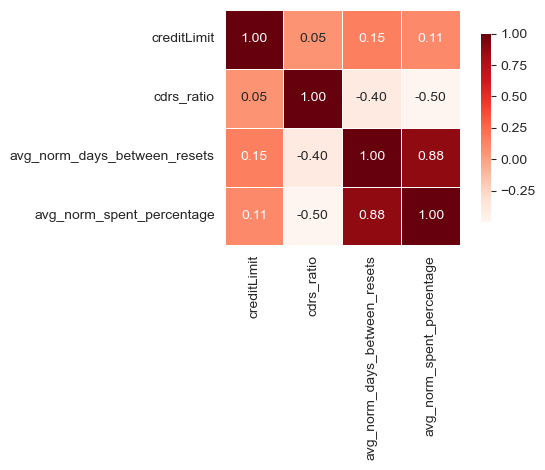

In [358]:
pltUtils.plot_correlation_heatmap(stability_stats_full, ['creditLimit', 'cdrs_ratio', 'avg_norm_days_between_resets', 'avg_norm_spent_percentage'], cmap="Reds")

In [359]:
both_avg_stats_is_na_accounts = stability_stats_full[(stability_stats_full['avg_norm_days_between_resets'].isnull()) & (
    stability_stats_full['avg_norm_spent_percentage'].isnull())]['accountNumber']
stab_df_both_avg_stats_is_na_accounts = stability_stats_full[
    stability_stats_full['accountNumber'].isin(both_avg_stats_is_na_accounts)]
stab_df_both_avg_stats_is_na_accounts

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
74,112169253,7500.0,NaN,NaN,NaN,NaN
187,133296468,1000.0,NaN,NaN,NaN,NaN
315,155162628,1000.0,NaN,NaN,NaN,NaN
344,160385576,7500.0,NaN,NaN,NaN,NaN
446,175371728,2500.0,NaN,NaN,NaN,NaN
639,211045558,10000.0,NaN,NaN,NaN,NaN
772,235216553,20000.0,NaN,NaN,NaN,NaN
849,248538348,20000.0,NaN,NaN,NaN,NaN
886,253391953,500.0,NaN,NaN,NaN,NaN
1059,287527885,15000.0,NaN,NaN,NaN,NaN


In [360]:
gen_df_with_both_invalid_avg_stats = df[df['accountNumber'].isin(both_avg_stats_is_na_accounts)]
print(
    f'Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: {gen_df_with_both_invalid_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_both_invalid_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_both_invalid_avg_stats[gen_df_with_both_invalid_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: 573
Number 573 is 0.06701527082707136% of 855029
Count of frauds transactions in gen dataset by these account numbers: 0


In [361]:
df.drop(index=gen_df_with_both_invalid_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_both_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4959 rows, 6 columns
Total NA's: 5164
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4959            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            1         
avg_norm_days_between_resets           float64    3133            55        
cdrs_ratio                             float64    2138            2403      
cdrs_range                             category   7               2705      


In [362]:
stab_df_invalid_spent_avg_stats_is_na_accounts = \
    stability_stats_full[stability_stats_full['avg_norm_spent_percentage'].isnull()]['accountNumber']
gen_df_with_invalid_spent_avg_stats = df[df['accountNumber'].isin(stab_df_invalid_spent_avg_stats_is_na_accounts)]

print(
    f'Count of account transactions where avg spent percentage btw resets in nan in stability stats: {gen_df_with_invalid_spent_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_invalid_spent_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_spent_avg_stats[gen_df_with_invalid_spent_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where avg spent percentage btw resets in nan in stability stats: 12
Number 12 is 0.0014044023331804096% of 854456
Count of frauds transactions in gen dataset by these account numbers: 0


In [363]:
df[df['accountNumber'] == '259711806']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud,creditLimitRange
154120,259711806,20000.0,20000.00,2016-09-13 09:44:41.000,20000.00,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,0.00,False,False,False,75-100%
154121,259711806,20000.0,20000.00,2016-09-14 09:44:41.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154122,259711806,20000.0,19993.42,2016-09-16 22:04:48.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154123,259711806,20000.0,19982.62,2016-10-01 10:43:33.500,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%
154124,259711806,20000.0,20000.00,2016-10-15 23:22:19.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154125,259711806,20000.0,19993.42,2016-10-17 06:06:18.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154126,259711806,20000.0,19982.62,2016-11-01 01:46:42.000,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%
154127,259711806,20000.0,20000.00,2016-11-15 21:27:06.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154128,259711806,20000.0,19993.42,2016-11-16 08:33:18.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154129,259711806,20000.0,19982.62,2016-12-01 21:12:57.000,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%


In [364]:
df.drop(index=gen_df_with_invalid_spent_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_invalid_spent_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4958 rows, 6 columns
Total NA's: 5161
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4958            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            0         
avg_norm_days_between_resets           float64    3133            55        
cdrs_ratio                             float64    2138            2402      
cdrs_range                             category   7               2704      


In [365]:

days_avg_stat_is_na_accounts = stability_stats_full[stability_stats_full['avg_norm_days_between_resets'].isnull()][
    'accountNumber']
stab_df_days_avg_stats_is_na_accounts = stability_stats_full[
    stability_stats_full['accountNumber'].isin(days_avg_stat_is_na_accounts)]
stab_df_days_avg_stats_is_na_accounts

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
59,110169390,15000.0,0.368713,NaN,NaN,NaN
65,110625245,500.0,0.500000,NaN,NaN,NaN
94,116858596,15000.0,0.090909,NaN,NaN,NaN
108,118650256,10000.0,0.888889,NaN,NaN,NaN
265,147940209,250.0,0.500000,NaN,NaN,NaN
318,155977598,5000.0,0.100000,NaN,NaN,NaN
321,156555865,20000.0,0.529953,NaN,NaN,NaN
559,196881494,20000.0,0.400000,NaN,NaN,NaN
675,219515030,1000.0,0.333333,NaN,NaN,NaN
676,219659566,5000.0,0.247080,NaN,NaN,NaN


In [366]:
gen_df_with_invalid_days_avg_stats = df[df['accountNumber'].isin(days_avg_stat_is_na_accounts)]
print(
    f'Count of account transactions where avg days btw resets in nan in stability stats: {gen_df_with_invalid_days_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_invalid_days_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0]}')

edaUtils.calculate_percentage(gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0],
                              df[df['isFraud'] == True].shape[0])

Count of account transactions where avg days btw resets in nan in stability stats: 35127
Number 35127 is 4.111094466108955% of 854444
Count of frauds transactions in gen dataset by these account numbers: 787
Number 787 is 6.3380848836272845% of 12417


In [367]:
df[df['accountNumber'] == '155977598']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud,creditLimitRange
51651,155977598,5000.0,5000.00,2016-02-27 15:29:21.000,5000.00,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,0.00,False,False,False,0-25%
51652,155977598,5000.0,5000.00,2016-02-28 15:29:21.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51653,155977598,5000.0,4977.65,2016-03-14 20:19:49.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51654,155977598,5000.0,5000.00,2016-03-30 01:10:18.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51655,155977598,5000.0,4977.65,2016-04-14 13:23:21.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51656,155977598,5000.0,5000.00,2016-04-30 01:36:25.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51657,155977598,5000.0,4977.65,2016-05-15 10:36:07.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51658,155977598,5000.0,5000.00,2016-05-30 19:35:50.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51659,155977598,5000.0,4977.65,2016-06-14 15:05:05.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51660,155977598,5000.0,5000.00,2016-06-29 10:34:21.000,34.55,US,US,02,08,food,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,True,False,False,0-25%


In [368]:
df.drop(index=gen_df_with_invalid_days_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_days_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4903 rows, 6 columns
Total NA's: 5000
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4903            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3711            0         
avg_norm_days_between_resets           float64    3133            0         
cdrs_ratio                             float64    2137            2349      
cdrs_range                             category   7               2651      


In [369]:
cdrs_ratio_is_0_accounts = stability_stats_full[stability_stats_full['cdrs_ratio'] == 0]['accountNumber']
stab_df_cdrs_ratio_is_0 = stability_stats_full[stability_stats_full['accountNumber'].isin(cdrs_ratio_is_0_accounts)]
stab_df_cdrs_ratio_is_0

,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
27,104048186,7500.0,1.000000,1.000000,0.0,NaN
39,105518929,500.0,0.519273,0.368132,0.0,NaN
52,108300020,20000.0,1.000000,1.000000,0.0,NaN
86,114895301,5000.0,0.448404,0.340336,0.0,NaN
103,118240481,15000.0,0.448924,0.430108,0.0,NaN
...,...,...,...,...,...,...
4922,985848672,5000.0,0.354490,0.560417,0.0,NaN
4928,987150360,2500.0,1.000000,1.000000,0.0,NaN
4965,993959615,5000.0,0.356652,0.401070,0.0,NaN
4986,997862042,500.0,0.473224,0.395349,0.0,NaN


In [370]:
gen_df_cdrs_ratio_is_0 = df[df['accountNumber'].isin(cdrs_ratio_is_0_accounts)]
print(f'Count of account transactions where cdrs ratio is 0 in stability stats: {gen_df_cdrs_ratio_is_0.shape[0]}')
edaUtils.calculate_percentage(gen_df_cdrs_ratio_is_0.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0]}')

edaUtils.calculate_percentage(gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0],
                              df[df['isFraud'] == True].shape[0])


Count of account transactions where cdrs ratio is 0 in stability stats: 70503
Number 70503 is 8.605094243131779% of 819317
Count of frauds transactions in gen dataset by these account numbers: 1011
Number 1011 is 8.693035253654342% of 11630


In [371]:
df.drop(index=gen_df_cdrs_ratio_is_0.index, inplace=True)
stability_stats_full.drop(index=cdrs_ratio_is_0_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4601 rows, 6 columns
Total NA's: 4698
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3505            0         
avg_norm_days_between_resets           float64    2965            0         
cdrs_ratio                             float64    2136            2349      
cdrs_range                             category   7               2349      


In [372]:
stability_stats_full_test_pred_df = stability_stats_full.copy()
stability_stats_full_test_pred_df.dropna(inplace=True)
cdrs_range_encoder = LabelEncoder()

stability_stats_full_test_pred_df['cdrs_range_encoded'] = cdrs_range_encoder.fit_transform(
    stability_stats_full_test_pred_df['cdrs_range'])
edaUtils.data_summary(stability_stats_full_test_pred_df)


Dimensions: 2252 rows, 7 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     2252            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    2221            0         
avg_norm_days_between_resets           float64    1848            0         
cdrs_ratio                             float64    2136            0         
cdrs_range                             category   7               0         
cdrs_range_encoded                     int32      7               0         


In [373]:
X_stats_full = stability_stats_full_test_pred_df.drop(
    columns=['cdrs_range', 'cdrs_range_encoded', 'cdrs_ratio', 'accountNumber'])
Y_stats_full = stability_stats_full_test_pred_df['cdrs_range_encoded']

X_stats_full_train, X_stats_full_test, Y_stats_full_train, Y_stats_full_test = train_test_split(X_stats_full,
                                                                                                Y_stats_full,
                                                                                                test_size=0.2,
                                                                                                random_state=101)

In [374]:
cdrs_range_encoded_weights = compute_class_weight('balanced', classes=Y_stats_full_train.unique(), y=Y_stats_full_train)
print(f'Cdrs range distribution weights in train dataset {cdrs_range_encoded_weights}')

Cdrs range distribution weights in train dataset [18.37755102  0.62752613  0.35684565  0.44901521  3.38533835 64.32142857
 85.76190476]


In [375]:
cdrs_range_best_model, cdrs_trained_models = mteUtils.load_or_tune_and_evaluate_models('cdrs_ratio_predictor', mteUtils.models_dictionary, X_stats_full_train, X_stats_full_test, Y_stats_full_train, Y_stats_full_test, re_train=False)

INFO:utils.ModelTrainingAndEvaluationUtils:------------------------------
Starting tuning for model: LogisticRegression
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Objects successfully serialized into ../../model/saved/cdrs_ratio_predictor\cdrs_ratio_predictor_best.pkl
Objects successfully serialized into ../../model/saved/cdrs_ratio_predictor\cdrs_ratio_predictor_all.pkl


In [378]:
mteUtils.evaluate_models(cdrs_trained_models, Y_stats_full_test)

Model Name           Accuracy   ROC AUC    Precision  Recall     F1 Score  


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
pltUtils.plot_confusion_matrix_models(models=cdrs_trained_models, X_test=X_stats_full_test, Y_test=Y_stats_full_test)

In [ ]:
pltUtils.plot_feature_importances(models=cdrs_trained_models, feature_names=list(X_stats_full_test.columns))

In [ ]:
edaUtils.data_summary(stability_stats_full)

In [ ]:
empty_cdrs_ratio_accounts = stability_stats_full[stability_stats_full['cdrs_range'].isnull()]
data_for_cdrs_range_prediction = empty_cdrs_ratio_accounts.drop(columns=['cdrs_ratio', 'cdrs_range', 'accountNumber'])
encoded_predicted_cdrs_range = cdrs_range_best_model.predict(data_for_cdrs_range_prediction)
empty_cdrs_ratio_accounts['cdrs_range'] = cdrs_range_encoder.inverse_transform(encoded_predicted_cdrs_range)

mean_cdrs_ratio_per_range = stability_stats_full[stability_stats_full['cdrs_range'].notna()].groupby('cdrs_range')['cdrs_ratio'].mean()
def fill_na_with_mean(row):
    if pd.isna(row['cdrs_ratio']):
        return mean_cdrs_ratio_per_range[row['cdrs_range']]
    else:
        return row['cdrs_ratio']

empty_cdrs_ratio_accounts['cdrs_ratio'] = empty_cdrs_ratio_accounts.apply(fill_na_with_mean, axis=1)

stability_stats_full.loc[
    stability_stats_full['accountNumber'].isin(empty_cdrs_ratio_accounts['accountNumber']),
    ['cdrs_range', 'cdrs_ratio']
] = empty_cdrs_ratio_accounts[['cdrs_range', 'cdrs_ratio']].values

stability_stats_full


In [ ]:
edaUtils.data_summary(stability_stats_full)

In [ ]:
visualize_fraud_vs_cdrs_ratio(calculate_fraud_stats(df, stability_stats_full))

#### Add cdrs ratio and range to general dataset and drop synthetic replenishment transactions

In [ ]:
cdrs_ratio_data = stability_stats_full[['accountNumber', 'cdrs_ratio', 'cdrs_range']]
df = df.merge(cdrs_ratio_data, on='accountNumber', how='left')
df = df[df['transactionType'] != 'REPLENISHMENT']
df.head()

In [ ]:
edaUtils.data_summary(df)

### Creating a new feature (MATCH ENTERED CVV OR NOT)

In [ ]:
df['cvv_matched_status'] = [True if actual_cvv == entered_cvv else False for actual_cvv, entered_cvv in zip(df['cardCVV'], df['enteredCVV'])]
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)
edaUtils.data_summary(df)

### Creating a new feature (Address change count)

In [ ]:
def add_address_change_count_column(df):
    """
    Adds a new column 'addressChangeCount' to the DataFrame with the number of address changes
    per account up to the time of each transaction.

    Parameters:
    df (pd.DataFrame): The dataset containing transactions.

    Returns:
    pd.DataFrame: Updated DataFrame with the new 'addressChangeCount' column.
    """
    # Convert columns with dates to datetime format
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

    # Sort by accountNumber and transactionDateTime to ensure correct order
    df = df.sort_values(by=['accountNumber', 'transactionDateTime'])

    # Initialize a new column for address change count
    df['addressChangeCount'] = 0

    # Group by account number to process each account's transactions individually
    for account, group in df.groupby('accountNumber'):
        address_changes = 0
        last_change_date = None

        # Iterate through each transaction for the account
        for idx, row in group.iterrows():
            # Check if the current transaction date is after the last address change
            if last_change_date is None or row['dateOfLastAddressChange'] > last_change_date:
                address_changes += 1
                last_change_date = row['dateOfLastAddressChange']

            # Set the count of address changes up to the current transaction
            df.at[idx, 'addressChangeCount'] = address_changes - 1

    return df

In [ ]:
df = stage_data_io_service.run_or_load_snapshot_data('add_address_change_count_column', add_address_change_count_column, df, recreate_snapshot=False)

In [ ]:
edaUtils.data_summary(df)

In [ ]:
def find_suspicious_transactions(df, time_threshold_milliseconds):
    """
    Identify suspicious transactions within a specified time threshold.

    Parameters:
    df (pd.DataFrame): The transaction dataset, which includes 'accountNumber', 'transactionDateTime', and 'transactionAmount'.
    time_threshold_milliseconds (int): The time window in milliseconds within which multiple transactions of the same amount are flagged as suspicious.

    Returns:
    pd.DataFrame: The original DataFrame with an additional 'is_suspicious' column.
    """
    # Sort by 'accountNumber' and 'transactionDateTime' to arrange transactions chronologically by account
    df = df.sort_values(['accountNumber', 'transactionDateTime']).reset_index(drop=True)
    
    # Check for duplicate transaction amounts for each account using `transform` to maintain DataFrame shape
    is_duplicate_amount = df.groupby('accountNumber')['transactionAmount'].transform(lambda x: x.duplicated())
    
    # Calculate time difference between consecutive transactions for each account in milliseconds
    is_within_time_threshold = df.groupby('accountNumber')['transactionDateTime'].diff() <= pd.Timedelta(time_threshold_milliseconds, unit='milliseconds')
    
    # Combine conditions: duplicate amount and time difference within threshold
    df["is_suspicious"] = is_duplicate_amount & is_within_time_threshold
    
    return df

In [ ]:
df = find_suspicious_transactions(df, time_threshold_milliseconds=3 * 60 * 1000)
suspicious_df = df[df['is_suspicious'] == True]

print("Total number of suspicious transactions: {}".format(suspicious_df.shape[0]))
print("Total transaction amount of suspicious transactions: {}$".format(round(suspicious_df['transactionAmount'].sum(), 2)))
edaUtils.data_summary(df)

## Preparing df for Model building

In [ ]:
fraud_modelling_df = df.drop(columns=[
    'accountNumber',
    'transactionDateTime',
    'currentExpDate',
    'accountOpenDate',
    'dateOfLastAddressChange'
])
fraud_modelling_df.columns

In [ ]:
fraud_modelling_df, encoders = dtUtils.encode_categorical_columns(fraud_modelling_df, [
    'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'creditLimitRange', 'cdrs_range'
])

In [ ]:
fraud_modelling_df = dtUtils.convert_bool_columns_to_int(fraud_modelling_df, ['cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'cvv_matched_status', 'is_suspicious'])

In [ ]:

def custom_train_test_split(data, target_column, test_size=0.2, random_state=None):
    """
    Splits the dataset into training and testing sets with an equal proportion
    of fraud cases (`target_column=True`) in both sets.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - target_column (str): The column name indicating the target variable (e.g., 'isFraud').
    - test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
    - random_state (int): Random seed for reproducibility (default is None).

    Returns:
    - X_train, X_test, y_train, y_test: Train-test splits for features and target.
    """
    # Separate fraud and non-fraud cases
    fraud_data = data[data[target_column] == True]
    non_fraud_data = data[data[target_column] == False]
    
    # Split fraud cases equally between train and test
    fraud_train, fraud_test = train_test_split(
        fraud_data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split non-fraud cases randomly based on test_size
    non_fraud_train, non_fraud_test = train_test_split(
        non_fraud_data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Combine train and test splits
    train_data = pd.concat([fraud_train, non_fraud_train]).sample(frac=1, random_state=random_state)
    test_data = pd.concat([fraud_test, non_fraud_test]).sample(frac=1, random_state=random_state)
    
    # Separate features and target
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, Y_train, Y_test = custom_train_test_split(fraud_modelling_df, target_column="isFraud", test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)} (Fraud count: {sum(Y_train)})")
print(f"Test size: {len(X_test)} (Fraud count: {sum(Y_test)})")

In [ ]:
pltUtils.plot_barplot_distribution(Y_train, 'Transaction Count by isFraud Value (without sampling)')

In [ ]:
X_train, Y_train = dtUtils.sample_features_target(X_train, Y_train, method='undersample')

In [ ]:
pltUtils.plot_barplot_distribution(Y_train, 'Transaction Count by isFraud Value (after undersampling)')

In [ ]:
stage_data_io_service.write_stage_data(X_train, X_test, Y_train, Y_test)